In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import resample

import numpy as np

np.random.seed(30)

In [2]:
df = pd.read_csv("2025_ems_to_crash_people_36hrs_v2.csv")

In [3]:
df = df[df["geo_distance"] <= 2500]
df = df[df["timestamp_distance_minutes"] <= 60 * 3]

In [4]:
# Converting bool -> int 
bool_cols = df.select_dtypes(include='bool').columns.tolist()
for col in bool_cols:
    df[col] = df[col].astype(int)

In [5]:
features = ["geo_distance",
    "age_distance",
    "transport_similarity",
    "address_similarity",
    "timestamp_distance_minutes",
    "is_sex_match",
    "is_case_id_match",
    "is_ethnicity_match",
    "is_inj_sev_match",
    "is_position_match",
    "is_mode_match",
    "is_transport_dest_match",
    "people_count_diff",
    "injury_count_diff",
]
# df.dropna(subset=features, inplace=True)

In [6]:
# Separate features and target
X = df[features]
y = df['is_matching_record']

In [7]:
# Check class distribution
print(f"Original class distribution:\n{y.value_counts()}\n")

Original class distribution:
is_matching_record
0    9870
1    3213
Name: count, dtype: int64



In [8]:
# ========================================
# OPTION 1: Balance the dataset first, then split
# ========================================

# Separate majority and minority classes
df_majority = df[df.is_matching_record == 0]
df_minority = df[df.is_matching_record == 1]

# Downsample majority class to match minority (1:1 ratio)
# df_majority_downsampled = resample(df_majority, 
#                                     replace=False,    # sample without replacement
#                                     n_samples=len(df_minority),
#                                     random_state=42)

# Or create 1:3 ratio (3 negatives for every 1 positive)
df_majority_downsampled = resample(df_majority, 
                                    replace=False,
                                    n_samples=len(df_minority) * 3,
                                    random_state=42)


In [9]:
# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced class distribution:\n{df_balanced.is_matching_record.value_counts()}\n")

# Now split the balanced dataset
X_balanced = df_balanced[features]
y_balanced = df_balanced['is_matching_record']

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, 
    test_size=0.2, 
    random_state=42,
    stratify=y_balanced  # Maintain class distribution in splits
)

Balanced class distribution:
is_matching_record
0    9639
1    3213
Name: count, dtype: int64



In [10]:
xgb = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),  # Handle imbalance
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBClassifier:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_xgb):.3f}\n")

XGBClassifier:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1928
           1       0.97      0.99      0.98       643

    accuracy                           0.99      2571
   macro avg       0.98      0.99      0.99      2571
weighted avg       0.99      0.99      0.99      2571

ROC AUC: 0.999



In [11]:
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

# Find wrong predictions
errors_mask = (y_pred != y_test)
print(f"Total errors: {errors_mask.sum()} out of {len(y_test)} ({100*errors_mask.sum()/len(y_test):.2f}%)")


Total errors: 23 out of 2571 (0.89%)


In [12]:
# False Positives: Predicted match (1) but actually not a match (0)
false_positives = (y_pred == 1) & (y_test == 0)
print(f"\nFalse Positives: {false_positives.sum()}")

# False Negatives: Predicted not a match (0) but actually a match (1)
false_negatives = (y_pred == 0) & (y_test == 1)
print(f"False Negatives: {false_negatives.sum()}")


False Positives: 19
False Negatives: 4


In [13]:
if errors_mask.sum() > 0:
    errors_df = pd.DataFrame({
        'true_label': y_test[errors_mask],
        'predicted_label': y_pred[errors_mask],
        'predicted_probability': y_proba[errors_mask]
    })
    
    # Add all features
    errors_df = pd.concat([errors_df, X_test[errors_mask]], axis=1)
    
    # Save to CSV
    errors_df.to_csv('model_errors.csv', index=True)
    print(f"\n✓ Saved {len(errors_df)} errors to 'model_errors.csv'")



✓ Saved 23 errors to 'model_errors.csv'


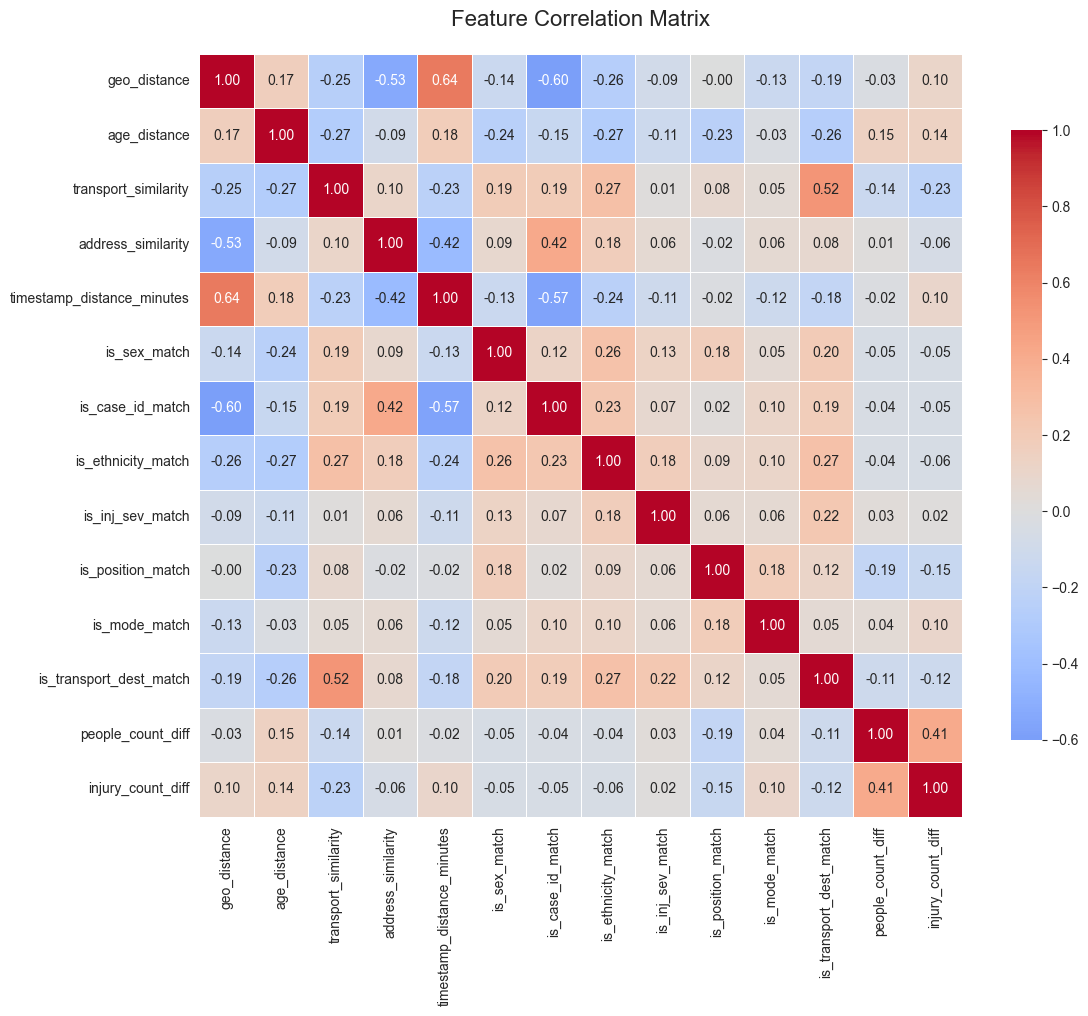

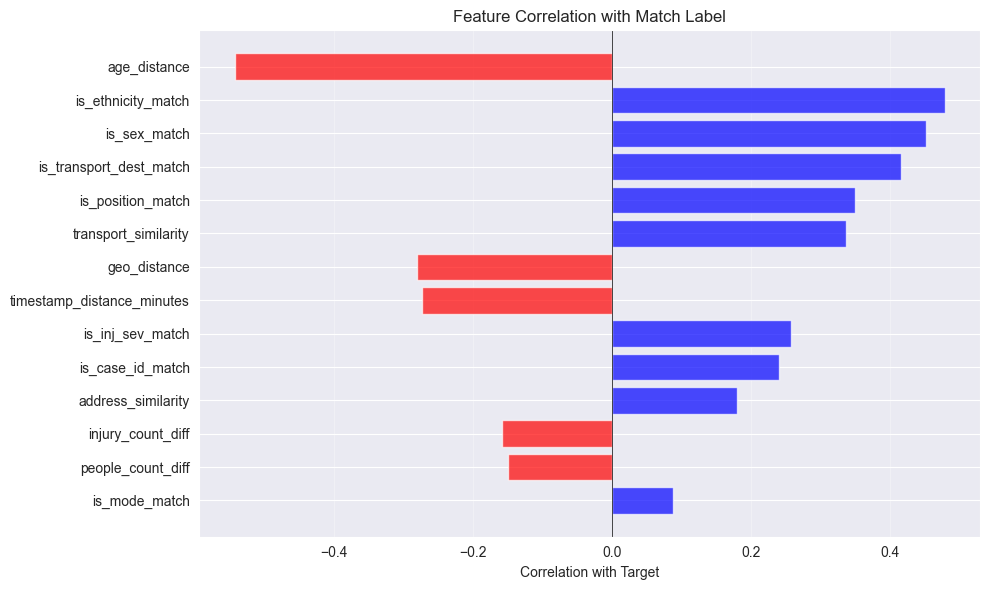

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================
# Basic correlation matrix
# ========================================

# Calculate correlation matrix
corr_matrix = X.corr()

# ========================================
# Visualize with heatmap
# ========================================

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='coolwarm',      # Color scheme
            center=0,             # Center colormap at 0
            square=True,          # Square cells
            linewidths=0.5,       # Grid lines
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# ========================================
# Find highly correlated pairs
# ========================================

# Get correlation pairs (upper triangle only to avoid duplicates)
corr_pairs = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Stack and sort by correlation
corr_pairs = corr_pairs.stack().sort_values(ascending=False)

# Show pairs with correlation > 0.7 or < -0.7
high_corr = corr_pairs[(corr_pairs > 0.7) | (corr_pairs < -0.7)]


# Show moderate correlations too
moderate_corr = corr_pairs[(corr_pairs > 0.5) & (corr_pairs <= 0.7) | 
                           (corr_pairs < -0.5) & (corr_pairs >= -0.7)]

# ========================================
# Correlation with target variable
# ========================================

# Combine features with target
X_with_target = pd.concat([X, y], axis=1)

# Calculate correlation with target
target_corr = X_with_target.corr()['is_matching_record'].drop('is_matching_record').sort_values(ascending=False)


# ========================================
# Visualize top correlations with target
# ========================================

plt.figure(figsize=(10, 6))
target_corr_sorted = target_corr.abs().sort_values(ascending=True)
colors = ['red' if x < 0 else 'blue' for x in target_corr[target_corr_sorted.index]]

plt.barh(range(len(target_corr_sorted)), 
         target_corr[target_corr_sorted.index],
         color=colors,
         alpha=0.7)
plt.yticks(range(len(target_corr_sorted)), target_corr_sorted.index)
plt.xlabel('Correlation with Target')
plt.title('Feature Correlation with Match Label')
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('target_correlation.png', dpi=150, bbox_inches='tight')
plt.show()